# Implementation of a Devito self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Nonlinear Ops --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. There are three notebooks in this series:

##### 1. Implementation of a Devito self adjoint variable density visco- acoustic isotropic modeling operator -- Nonlinear Ops
- Implement the nonlinear modeling operations. 
- [sa_01_iso_implementation1.ipynb](sa_01_iso_implementation1.ipynb)

##### 2. Implementation of a Devito self adjoint variable density visco- acoustic isotropic modeling operator -- Linearized Ops
- Implement the linearized (Jacobian) ```forward``` and ```adjoint``` modeling operations.
- [sa_02_iso_implementation2.ipynb](sa_02_iso_implementation2.ipynb)

##### 3. Implementation of a Devito self adjoint variable density visco- acoustic isotropic modeling operator -- Correctness Testing
- Tests the correctness of the implemented operators.
- [sa_03_iso_correctness.ipynb](sa_03_iso_correctness.ipynb)

There are similar series of notebooks implementing and testing operators for VTI and TTI anisotropy ([README.md](README.md)).

Below we introduce the *self adjoint* form of the scalar isotropic variable density visco- acoustic wave equation with a simple form of dissipation only Q attenuation. This dissipation only (no dispersion) attenuation term $\left (\frac{\displaystyle \omega}{Q}\ \partial_t\ u \right)$ is an approximation of a [Maxwell Body](https://en.wikipedia.org/wiki/Maxwell_material) -- that is to say viscoelasticity approximated with a spring and dashpot in series. In practice this approach for attenuating outgoing waves is very similar to the Cerjan style damping in absorbing boundaries used elsewhere in Devito ([References](#nl_refs)). 

The derivation of the attenuation model is not in scope for this tutorial, but one important point is that the physics in the absorbing boundary region and the interior of the model are *unified*, allowing the same modeling equations to be used everywhere, with physical Q values in the interior tapering to non-physical small Q at the boundaries to attenuate outgoing waves. 

## Outline 
1. Define symbols
2. Introduce the SA wave equation
3. Show generation of skew symmetric derivatives and prove correctness with unit test
4. Derive the time update equation used to implement the nonlinear forward modeling operator
5. Create the Devito grid and model fields
6. Define a function to implement the attenuation profile ($\omega\ /\ Q$)
7. Create the Devito operator 
8. Run the Devito operator 
9. Plot the resulting wavefields
10. References 


## Table of symbols

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
| :---         | :---              | :--- |
| $\omega_c = 2 \pi f_c$ | center angular frequency | constant |
| $m(x,y,z)$   | P wave velocity    | function of space |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $u(t,x,y,z)$ | Pressure wavefield | function of time and space |
| $q(t,x,y,z)$ | Source term        | function of time, localized in space |
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | centered in time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ |  

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x}\ u(t,x,y,z)$ indicates that the $x$ derivative of $u(t,x,y,z)$ is taken at $u(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z}\ u(t,x,y,z)$ indicates that the $z$ derivative of $u(t,x,y,z)$ is taken at $u(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t}\ u(t,x,y,z)$ indicates that the $t$ derivative of $u(t,x,y,z)$ is taken at $u(t-\frac{\Delta_t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $u(t,x,y,z)$ becomes $u$.

## Self adjoint variable density visco- acoustic wave equation

Our self adjoint wave equation is written:

$$
\frac{b}{m^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ u + \partial_{tt}\ u \right) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + q
$$

An advantage of this form is that the same system can be used to provide *stable modes of propagation* for all operations needed in quasi- Newton optimization: 

- the nonlinear forward 
- the linearized forward (Jacobian forward)
- the linearized adjoint (Jacobian adjoint)

This advantage is more important for anisotropic operators, where widely utilized non energy conserving formulations can provide unstable adjoints and thus unstable gradients for anisotropy parameters.  

The *self adjoint* formulation is evident in the shifted spatial derivatives, with the derivative on the right side $\overrightarrow{\partial}$ shifting forward in space one-half cell, and the derivative on the left side $\overleftarrow{\partial}$ shifting backward in space one-half cell. 

$\overrightarrow{\partial}$ and $\overleftarrow{\partial}$ are anti-symmetric (also known as skew symmetric), meaning that for two random vectors $x_1$ and $x_2$, correctly implemented numerical derivatives will have the following property:

$$
x_2 \cdot \left( \overrightarrow{\partial_x}\ x_1 \right) \approx -\ 
x_1 \cdot \left( \overleftarrow{\partial_x}\ x_2 \right) 
$$

Below we will demonstrate this skew symmetry with a simple unit test on Devito generated derivatives. 

In the following notebooks in this series, material parameters *sandwiched* between the derivatives -- including anisotropy parameters -- become much more interesting, but here buoyancy $b$ is the only material parameter between derivatives in our self adjoint (SA) wave equation. 

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [2]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.self_adjoint import setup_w_over_q
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer
# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'

## Unit test demonstrating skew symmetry for shifted derivatives

As noted above, we prove with a small 1D unit test and 8th order spatial operator that the Devito shifted first derivatives are skew symmetric. This anti-symmetry can be demonstrated for the forward and backward half cell shift first derivative operators $\overrightarrow{\partial}$ and $\overleftarrow{\partial}$ with two random vectors $x_1$ and $x_2$ by verifying the *dot product test* as written above.

We will use Devito to implement the following two equations with an ```Operator```:

$$
\begin{aligned}
f_2 = \overrightarrow{\partial_x}\ f_1 \\[5pt]
g_2 = \overleftarrow{\partial_x}\ g_1
\end{aligned}
$$

And then verify the dot products are equivalent. Recall that skew symmetry introduces a minus sign in this equality:  

$$
f_1 \cdot g_2 \approx - g_1 \cdot f_2
$$

We use the following test for relative error (note the flipped signs in numerator and denominator due to anti- symmetry):

$$
\frac{\displaystyle f_1 \cdot g_2 + g_1 \cdot f_2}
     {\displaystyle f_1 \cdot g_2 - g_1 \cdot f_2}\ <\ \epsilon
$$


In [3]:
# NBVAL_IGNORE_OUTPUT

# Make 1D grid to test derivatives 
n = 101
d = 1.0
shape = (n, )
spacing = (1 / (n-1), )   
origin = (0., )
extent = (d * (n-1), )
dtype = np.float64
so = 8

# Initialize Devito grid and Functions for input(f1,g1) and output(f2,g2)
# Note that space_order=8 allows us to use an 8th order finite difference 
#   operator by properly setting up grid accesses with halo cells 
grid1d = Grid(shape=shape, extent=extent, origin=origin, dtype=dtype)
x = grid1d.dimensions[0]
f1 = Function(name='f1', grid=grid1d, space_order=so)
f2 = Function(name='f2', grid=grid1d, space_order=so)
g1 = Function(name='g1', grid=grid1d, space_order=so)
g2 = Function(name='g2', grid=grid1d, space_order=so)

# Fill f1 and g1 with random values in [-1,+1]
f1.data[:] = -1 + 2 * np.random.rand(n,)
g1.data[:] = -1 + 2 * np.random.rand(n,)

# Equation defining: [f2 = forward 1/2 cell shift derivative applied to f1]
equation_f2 = Eq(f2, f1.dx(x0=x+0.5*x.spacing))

# Equation defining: [g2 = backward 1/2 cell shift derivative applied to g1]
equation_g2 = Eq(g2, g1.dx(x0=x-0.5*x.spacing))

# Define an Operator to implement these equations and execute
op = Operator([equation_f2, equation_g2])
op()

# Compute the dot products and the relative error
f1g2 = np.dot(f1.data, g2.data)
g1f2 = np.dot(g1.data, f2.data)
diff = (f1g2+g1f2)/(f1g2-g1f2)

tol = 100 * np.finfo(dtype).eps
print("f1g2, g1f2, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (f1g2, g1f2, diff, tol))

# At last the unit test
# Assert these dot products are float epsilon close in relative error
assert diff < 100 * np.finfo(dtype).eps

Allocating host memory for f1(117,) [936 B]
Allocating host memory for g1(117,) [936 B]
Operator `Kernel` generated in 0.37 s
  * lowering.Expressions: 0.18 s (49.6 %)
  * lowering.Clusters: 0.10 s (27.6 %)
     * specializing.Clusters: 0.09 s (24.8 %)
  * lowering.IET: 0.08 s (22.1 %)
Flops reduction after symbolic optimization: [62 --> 25]
Allocating host memory for f2(117,) [936 B]
Allocating host memory for g2(117,) [936 B]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid1000/13c8427003da95c428c3e052444944ed727e41f8.c` in 0.08 s from jit-cache
Operator `Kernel` ran in 0.01 s
Global performance: [OI=0.76, 0.13 GFlops/s]
Local performance:
  * section0<101> ran in 0.01 s [OI=0.76, 0.85 GFlops/s]
Performance[mode=advanced] arguments: {}


f1g2, g1f2, diff, tol; -1.803093e+00 +1.803093e+00 +6.157325e-17 +2.220446e-14


## Show the finite difference operators and generated code

You can inspect the finite difference coefficients and locations for evaluation with the code shown below. 

For your reference, the finite difference coefficients seen in the first two stanzas below are exactly the coefficients generated in Table 2 of Fornberg's paper **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** linked below ([References](#nl_refs)).

Note that you don't need to inspect the generated code, but this does provide the option to use this highly optimized code in applications that do not need or require python. If you inspect the code you will notice hallmarks of highly optimized c code, including ```pragmas``` for vectorization, and ```decorations``` for pointer restriction and alignment. 

In [4]:
# NBVAL_IGNORE_OUTPUT

# Show the FD coefficients generated by Devito 
# for the forward 1/2 cell shifted first derivative operator
print("\n\nForward +1/2 cell shift;")
print("..................................")
print(f1.dx(x0=x+0.5*x.spacing).evaluate)

# Show the FD coefficients generated by Devito 
# for the backward 1/2 cell shifted first derivative operator
print("\n\nBackward -1/2 cell shift;")
print("..................................")
print(f1.dx(x0=x-0.5*x.spacing).evaluate)

# Show code generated by Devito for applying the derivatives
print("\n\nGenerated c code;")
print("..................................")
print(op.ccode)



Forward +1/2 cell shift;
..................................
-1.19628906*f1(x)/h_x + 0.000697544643*f1(x - 3*h_x)/h_x - 0.0095703125*f1(x - 2*h_x)/h_x + 0.0797526042*f1(x - h_x)/h_x + 1.19628906*f1(x + h_x)/h_x - 0.0797526042*f1(x + 2*h_x)/h_x + 0.0095703125*f1(x + 3*h_x)/h_x - 0.000697544643*f1(x + 4*h_x)/h_x


Backward -1/2 cell shift;
..................................
1.19628906*f1(x)/h_x + 0.000697544643*f1(x - 4*h_x)/h_x - 0.0095703125*f1(x - 3*h_x)/h_x + 0.0797526042*f1(x - 2*h_x)/h_x - 1.19628906*f1(x - h_x)/h_x - 0.0797526042*f1(x + h_x)/h_x + 0.0095703125*f1(x + 2*h_x)/h_x - 0.000697544643*f1(x + 3*h_x)/h_x


Generated c code;
..................................
#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.

## Doing some algebra to solve for the time update

The next step in implementing our Devito modeling operator is to define the equation used to update the pressure wavefield as a function of time. What follows is a bit of algebra using the wave equation and finite difference approximations to time derivatives to express the pressure wavefield forward in time $u(t+\Delta_t)$ as a function of the current $u(t)$ and previous $u(t-\Delta_t)$ pressure wavefields.

#### 1. Numerical approximation for $\partial_{tt}\ u$, solved for for $u(t+\Delta_t)$
The second order accurate centered approximation to the second time derivative involves three wavefields: $u(t-\Delta_t)$, $u(t)$, and $u(t+\Delta_t)$. In order to advance our finite difference solution in time, we solve for $u(t+\Delta_t)$.

$$
\begin{aligned}
\partial_{tt}\ u &= \frac{\displaystyle u(t+\Delta_t) 
    - 2\ u(t) + u(t-\Delta_t)}{\displaystyle \Delta_t^2} \\[5pt]
u(t+\Delta_t)\ &= \Delta_t^2\ \partial_{tt}\ u + 2\ u(t) - u(t-\Delta_t)
\end{aligned}
$$

#### 2. Numerical approximation for $\overleftarrow{\partial_{t}}\ u$
The argument for using a backward approximation is a bit hand wavy, but goes like this: a centered or forward approximation for $\partial_{t}\ u$ would involve the term $u(t+\Delta_t)$, and hence $u(t+\Delta_t)$ would appear at two places in our time update equation below, essentially making the form implicit (although it would be easy to solve for $u(t+\Delta_t)$). 

We are interested in explicit time stepping and the correct behavior of the attenuation term, and so prefer the backward approximation for $\overleftarrow{\partial_{t}}\ u$. Our experience is that the use of the backward difference is more stable than forward or centered.

The first order accurate backward approximation to the first time derivative involves two wavefields: $u(t-\Delta_t)$, and $u(t)$. We can use this expression as is. 

$$
\overleftarrow{\partial_{t}}\ u = \frac{\displaystyle u(t) - u(t-\Delta_t)}{\displaystyle \Delta_t}
$$

#### 3. Solve the wave equation for $\partial_{tt}$

$$
\begin{aligned}
\frac{b}{m^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_{t}}\ u +
    \partial_{tt}\ u \right) &=
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + q\\[10pt]
    \partial_{tt}\ u &=
    \frac{m^2}{b} \left[ 
        \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
        \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
        \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + q
    \right] 
    - \frac{\omega_c}{Q} \overleftarrow{\partial_{t}}\ u
\end{aligned}
$$

#### 4. Plug in $\overleftarrow{\partial_t} u$ and $\partial_{tt} u$ into the time update equation 
Next we plug in the right hand sides for $\partial_{tt}\ u$ and $\overleftarrow{\partial_{t}}\ u$ into the the time update expression for $u(t+\Delta_t)$ from step 2.

$$
\begin{aligned}
    u(t+\Delta_t) &= \Delta_t^2 
        \frac{m^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + q
        \right] \\[10pt]
        & \quad -\ \Delta_t^2 \frac{\omega_c}{Q}
            \left( \frac{\displaystyle u(t) - u(t-\Delta_t)}
                        {\displaystyle \Delta_t} \right) + 2\ u(t) - u(t-\Delta_t)
\end{aligned}
$$

#### 5. Simplify ...

$$
\begin{aligned}
    u(t+\Delta_t) &= \Delta_t^2 
        \frac{m^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + q
        \right] \\[10pt]
        & \quad \left(2 -\ \Delta_t\ \frac{\omega_c}{Q} \right) u(t)
        + \left(\Delta_t\ \frac{\omega_c}{Q} - 1 \right) u(t-\Delta_t)
\end{aligned}
$$

#### 6. et voila ...
The last equation is how we update the pressure wavefield at each time step, and depends on $u(t)$ and $u(t-\Delta_t)$. 

The main work of the finite difference explicit time stepping is evaluating the nested spatial derivative operators on the RHS of this equation. The particular advantage of Devito symbolic optimization is that Devito is able to solve for the complicated expressions that result from substituting the discrete forms of high order numerical finite difference approximations for these nested spatial derivatives.

We have now completed the maths required to implement the modeling operator. The remainder of this notebook deals with setting up and using the required Devito objects.


## Instantiate the Devito grid for a two dimensional problem

Define the dimensions and coordinates for the model. The computational domain of the model is surrounded by an *absorbing boundary region* where we implement boundary conditions to eliminate outgoing waves. We define the sizes for the interior of the model ```nx``` and ```nz```, the width of the absorbing boundary region ```npad```, and the sizes for the entire model padded with absorbing boundaries become ```nxpad = nx + 2*npad``` and ```nzpad = nz + 2*npad```.

In [5]:
# Define dimensions for the interior of the model
nx,nz = 751,751
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define dimensions for the model padded with absorbing boundaries
npad = 50          # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx+2*npad, nz+2*npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Define the dimensions 
# Note if you do not specify dimensions, you get in order x,y,z
x = SpaceDimension(name='x', spacing=Constant(name='h_x', 
                   value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', 
                   value=extent_pad[1]/(shape_pad[1]-1)))

# Initialize the Devito grid 
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, 
            dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

shape;            (751, 751)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (7500.0, 7500.0)

shape_pad;        [851 851]
origin_pad;       (-500.0, -500.0)
extent_pad;       (8500.0, 8500.0)

grid.shape;       (851, 851)
grid.extent;      (8500.0, 8500.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


## Define velocity and buoyancy model parameters

We have the following constants and fields from our self adjoint wave equation that we define as time invariant using ```Functions```:

| &nbsp; Symbol &nbsp; | Description |
| :---: | :--- |
| $$m(x,z)$$ | Acoustic velocity |
| $$b(x,z)=\frac{1}{\rho(x,z)}$$ | Buoyancy (reciprocal density) |

In [21]:
# Create the velocity and buoyancy fields. 
#   - We use a wholespace velocity of 1500 m/s
#   - We use a wholespace density of 1 g/cm^3
#   - These are scalar fields so we use Function to define them
#   - We specify space_order to establish the appropriate size halo on the edges 
space_order = 8

# Wholespace velocity
m = Function(name='m', grid=grid, space_order=space_order)
m.data[:] = 1.5
b_mod, v_mod = 0, 1
# Constant density
b = Function(name='b', grid=grid, space_order=space_order)
plonk = 284
if b_mod > 0: # Right case
    b.data[:plonk, :] = 1.0
    b.data[plonk : -plonk, :] = 1.0
    b.data[-plonk:, :] = 1.0 / 5.0
elif b_mod < 0: # Left case
    b.data[:plonk, :] = 1.0 / 5.0
    b.data[plonk : -plonk, :] = 1.0
    b.data[-plonk:, :] = 1.0
else:
    b.data[:plonk, :] = 1.0
    b.data[plonk : -plonk, :] = 1.0
    b.data[-plonk:, :] = 1.0
# velocity
if v_mod > 0: # Right case
    m.data[:plonk, :] = 1.5
    m.data[plonk : -plonk, :] = 1.5
    m.data[-plonk:, :] = 1.7
elif v_mod < 0: # Left case
    m.data[:plonk, :] = 1.7
    m.data[plonk : -plonk, :] = 1.5
    m.data[-plonk:, :] = 1.5
else:
    m.data[:plonk, :] = 1.5
    m.data[plonk : -plonk, :] = 1.5
    m.data[-plonk:, :] = 1.5
# plt.imshow(m.data.T)

Allocating host memory for m(867, 867) [6 MB]
Allocating host memory for b(867, 867) [6 MB]


## Define the simulation time range

In this notebook we run 2 seconds of simulation using the sample rate related to the CFL condition as implemented in ```examples/seismic/self_adjoint/utils.py```. 

**Important note** smaller Q values in highly viscous media may require smaller temporal sampling rates than a non-viscous medium to achieve dispersion free propagation. This is a cost of the visco- acoustic modification we use here.

We also use the convenience ```TimeRange``` as defined in ```examples/seismic/source.py```.

In [22]:
def compute_critical_dt(v):
    """
    Determine the temporal sampling to satisfy CFL stability.
    This method replicates the functionality in the Model class.
    Note we add a safety factor, reducing dt by a factor 0.75 due to the
    w/Q attentuation term.
    Parameters
    ----------
    v : Function
        velocity
    """
    coeff = 0.38 if len(v.grid.shape) == 3 else 0.42
    dt = 0.75 * v.dtype(coeff * np.min(v.grid.spacing) / (np.max(v.data)))
    return v.dtype("%.5e" % dt)

In [23]:
t0 = dtype(0.)     # Simulation time start
tn = dtype(2000.)  # Simulation time end (1 second = 1000 msec)
dt = compute_critical_dt(m)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min, max, dt, num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))
print("time_range; ", time_range)

Time min, max, dt, num;   0.000000 2000.000000   1.852940 1080
time_range;  TimeAxis: start=0, stop=2001.18, step=1.85294, num=1081


## Define the acquisition geometry: locations of sources and receivers 

**source**:
- X coordinate: center of the model: dx*(nx//2)
- Z coordinate: center of the model: dz*(nz//2)
- We use a 10 Hz center frequency [RickerSource](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L280) wavelet as defined in ```examples/seismic/source.py```

**receivers**:
- X coordinate: center of the model: dx*(nx//2)  
- Z coordinate: vertical line from top to bottom of model
- We use a vertical line of [Receivers](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L80) as defined with a ```PointSource``` in ```examples/seismic/source.py```

Allocating host memory for src(1081, 1) [8 KB]
Allocating host memory for src_coords(1, 2) [16 B]
Allocating host memory for rec_coords(751, 2) [12 KB]


[[3750. 3750.]]
src_coordinate  X;           +3750.0000
src_coordinate  Z;           +3750.0000
rec_coordinates X min/max;   +3750.0000   +3750.0000
rec_coordinates Z min/max;      +0.0000   +7500.0000


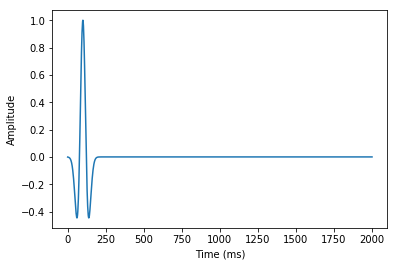

In [24]:
# NBVAL_IGNORE_OUTPUT
# Source in the center of the model at 10 Hz center frequency
fpeak = 0.010
src = RickerSource(name='src', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[0,0] = dx * (nx//2)
src.coordinates.data[0,1] = dz * (nz//2)
print(src.coordinates.data)
# line of receivers along the right edge of the model
rec = Receiver(name='rec', grid=grid, npoint=nz, time_range=time_range)
rec.coordinates.data[:,0] = dx * (nx//2)
rec.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("src_coordinate  X;         %+12.4f" % (src.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,0]), np.max(rec.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,1]), np.max(rec.coordinates.data[:,1])))

# We can plot the time signature to see the wavelet
src.show()

## Plot velocity and density models

Next we plot the velocity and density models for illustration. 
- The demarcation between interior and absorbing boundary is shown with a dotted white line
- The source is shown as a large red asterisk
- The extent of the receiver array is shown with a thick black line

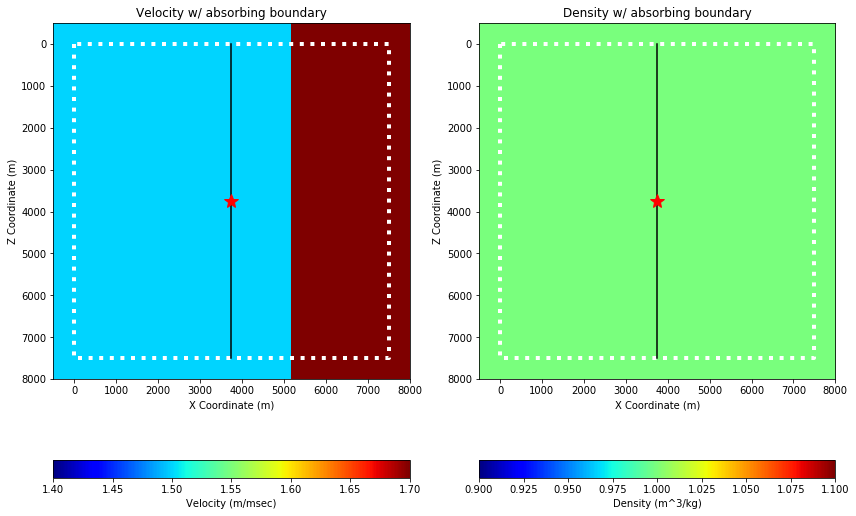

In [25]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

vmin, vmax = 1.4, 1.7
dmin, dmax = 0.9, 1.1

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(m.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity w/ absorbing boundary")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Density (m^3/kg)')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Density w/ absorbing boundary")

plt.tight_layout()
None

## Create and plot the $\frac{\omega_c}{Q}$ model used for dissipation only attenuation

We have two remaining constants and fields from our SA wave equation that we need to define:

| &nbsp; Symbol &nbsp; | Description |
| :---: | :--- |
| $$\omega_c = 2 \pi f_c$$      | Center angular frequency |
| $$\frac{1}{Q(x,z)}$$ | Inverse Q model used in the modeling system |

The absorbing boundary condition strategy we use is designed to eliminate any corners or edges in the attenuation profile. We do this by making Q a function of *distance from the nearest boundary*. 

We have implemented the function ```setup_w_over_q``` for 2D and 3D fields in the file ```utils.py```, and will use it below. In Devito these fields are type ```Function```, a concrete implementation of ```AbstractFunction```. 

Feel free to inspect the source at [utils.py](utils.py), which uses Devito's symbolic math to write a nonlinear equation describing the absorbing boundary for dispatch to automatic code generation. 

Note that we will generate two Q models, one with strong attenuation (a Q value of 25) and one with moderate attenuation (a Q value of 100) -- in order to demonstrate the impact of attenuation in the plots near the end of this notebook. 

w,fpeak;  0.06283185307179587 0.01


Operator `WOverQ_Operator` generated in 0.30 s
  * lowering.IET: 0.14 s (47.8 %)
     * specializing.IET: 0.10 s (34.1 %)
  * lowering.Clusters: 0.07 s (23.9 %)
  * lowering.Expressions: 0.07 s (23.9 %)
Flops reduction after symbolic optimization: [11 --> 11]
Allocating host memory for wOverQ_025(867, 867) [6 MB]
Operator `WOverQ_Operator` fetched `/tmp/devito-jitcache-uid1000/635d98a0a66735e3548f04a414485d8a2fc006ed.c` in 0.08 s from jit-cache
Operator `WOverQ_Operator` ran in 0.01 s
Global performance: [OI=0.01, 0.60 GFlops/s]
Local performance:
  * section0<<50,851>,<50,851>,<851,50>,<851,50>,<851,851>> ran in 0.01 s [OI=0.01, 0.60 GFlops/s]
Performance[mode=advanced] arguments: {}
Operator `WOverQ_Operator` generated in 0.28 s
  * lowering.IET: 0.13 s (46.9 %)
     * specializing.IET: 0.09 s (32.5 %)
  * lowering.Clusters: 0.07 s (25.3 %)
  * lowering.Expressions: 0.07 s (25.3 %)
Flops reduction after symbolic optimization: [11 --> 11]
Allocating host memory for wOverQ_100(867, 867

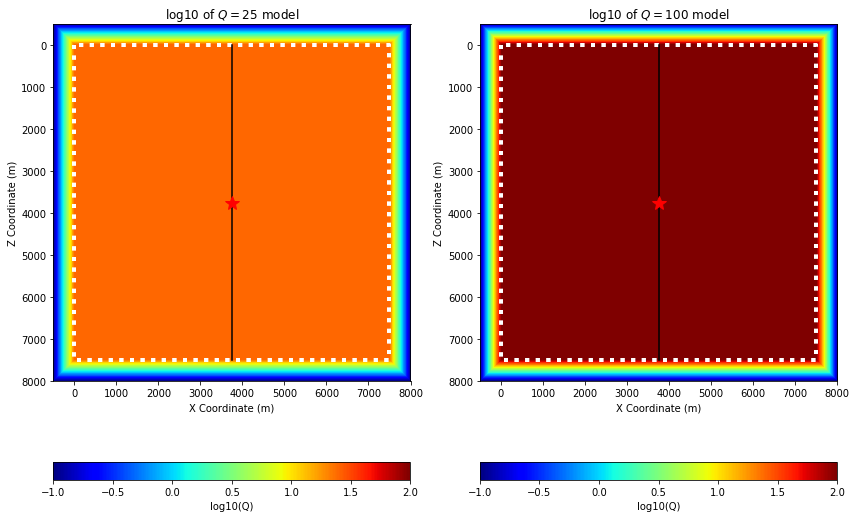

In [26]:
# NBVAL_IGNORE_OUTPUT

# Initialize the attenuation profile for Q=25 and Q=100 models
w = 2.0 * np.pi * fpeak
print("w,fpeak; ", w, fpeak)
qmin = 0.1

wOverQ_025 = Function(name='wOverQ_025', grid=grid, space_order=space_order)
wOverQ_100 = Function(name='wOverQ_100', grid=grid, space_order=space_order)

setup_w_over_q(wOverQ_025, w, qmin, 25.0, npad)
setup_w_over_q(wOverQ_100, w, qmin, 100.0, npad)

# Plot the log of the generated Q profile
q025 = np.log10(w / wOverQ_025.data)
q100 = np.log10(w / wOverQ_100.data)
lmin, lmax = np.log10(qmin), np.log10(100)

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(q025.data), cmap=cm.jet, 
           vmin=lmin, vmax=lmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='log10(Q)')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q=25$ model")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(q100.data), cmap=cm.jet,
           vmin=lmin, vmax=lmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='log10(Q)')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q=100$ model")

plt.tight_layout()
None

## Define the pressure wavefield as a ```TimeFunction```

We specify the time_order as 2, which allocates 3 time steps in the pressure wavefield. As described elsewhere, Devito will use "cyclic indexing" to index into this multi-dimensional array, mneaning that via the *modulo operator*, the time indices $[0, 1, 2, 3, 4, 5, ...]$ are mapped into the modulo indices $[0, 1, 2, 0, 1, 2, ...]$

This [FAQ entry](https://github.com/devitocodes/devito/wiki/FAQ#as-time-increases-in-the-finite-difference-evolution-are-wavefield-arrays-swapped-as-you-might-see-in-cc-code) explains in more detail.

In [27]:
# Define the TimeFunction
u = TimeFunction(name="u", grid=grid, time_order=2, space_order=space_order)

# Get the symbols for dimensions for t, x, z 
# We need these below in order to write the source injection and the
t,x,z = u.dimensions

## Define the source injection and receiver extraction 

If you examine the equation for the time update we derived above you will see that the source $q$ is scaled by the term $(\Delta_t^2 m^2\ /\ b)$. You will see that scaling term in the source injection below. For $\Delta_t^2$ we use the time dimension spacing symbol ```t.spacing**2```. 

Note that source injection and receiver extraction are accomplished via linear interpolation, as implemented in ```SparseTimeFunction``` in [sparse.py](https://github.com/devitocodes/devito/blob/master/devito/types/sparse.py#L747).


In [28]:
# Source injection, with appropriate scaling
src_term = src.inject(field=u.forward, expr=src * t.spacing**2 * m**2 / b)

# Receiver extraction 
rec_term = rec.interpolate(expr=u.forward)

## Finally, the Devito operator

We next transcribe the time update expression we derived above into a Devito ```Eq```. Then we add that expression with the source injection and receiver extraction and build an ```Operator``` that will generate the c code for performing the modeling.

We copy the time update expression from above for clarity. Note we omit $q$ because we will be explicitly injecting the source using ```src_term``` defined immediately above. However, for the linearized *Born forward modeling* operation the $q$ term is an appropriately scaled field, as shown in the next notebook in this series.  

$$
\begin{aligned}
    u(t+\Delta_t) &= \Delta_t^2 
        \frac{m^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + q
        \right] \\[10pt]
        & \quad \left(2 -\ \Delta_t\ \frac{\omega_c}{Q} \right) u(t)
        + \left(\Delta_t\ \frac{\omega_c}{Q} - 1 \right) u(t-\Delta_t)
\end{aligned}
$$


In [29]:
# NBVAL_IGNORE_OUTPUT

# Generate the time update equation and operator for Q=25 model
eq_time_update = (t.spacing**2 * m**2 / b) * \
    ((b * u.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ_025) * u + \
    (t.spacing * wOverQ_025 - 1) * u.backward

stencil = Eq(u.forward, eq_time_update)

# Update the dimension spacing_map to include the time dimension
# These symbols will be replaced with the relevant scalars by the Operator
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# op = Operator([stencil] + src_term + rec_term)
op = Operator([stencil] + src_term + rec_term, subs=spacing_map)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 1.85294}


Operator `Kernel` generated in 2.05 s
  * lowering.Expressions: 0.72 s (35.2 %)
  * lowering.Clusters: 0.68 s (33.3 %)
  * lowering.IET: 0.52 s (25.5 %)
Flops reduction after symbolic optimization: [300 --> 56]


## Impact of hardwiring the grid spacing on operation count

The argument ```subs=spacing_map``` passed to the operator substitutes values for the temporal and spatial dimensions into the expressions before code generation. This reduces the number of floating point operations executed by the kernel by pre-evaluating certain coefficients, and possibly absorbing the spacing scalars from the denominators of the numerical finite difference approximations into the finite difference coefficients.  

If you run the two cases of passing/not passing the ```subs=spacing_map``` argument by commenting/un-commenting the last two lines of the cell immediately above, you can inspect the difference in computed flop count for the operator. This is reported by setting Devito logging ```configuration['log-level'] = 'DEBUG'``` and is reported during Devito symbolic optimization with the output line ```Flops reduction after symbolic optimization```. Note also if you inspect the generated code for the two cases, you will see extra calling parameters are required for the case without the substitution. We have compiled the flop count for 2D and 3D operators into the table below.

| Dimensionality | Passing subs | Flops reduction | Delta |
|:---:|:---:|:---:|:---:|
| 2D | False | 588 --> 81  |       | 
| 2D | True  | 300 --> 68  | 13.7% |
| 3D | False | 875 --> 116 |       |
| 3D | True  | 442 --> 95  | 18.1% |

Note the gain in performance is around 14% for this example in 2D, and around 18% in 3D.

## Print the arguments to the Devito operator

We use ```op.arguments()``` to print the arguments to the operator. As noted above depending on the use of ```subs=spacing_map``` you will see different arguments here. In the case of no ```subs=spacing_map``` argument to the operator, you will see arguments for the dimensional spacing constants as parameters to the operator, including ```h_x```, ```h_z```, and ```dt```.

In [30]:
# NBVAL_IGNORE_OUTPUT

op.arguments()

Allocating host memory for rec(1081, 751) [6 MB]
Allocating host memory for u(3, 867, 867) [17 MB]


{'b': <cparam 'P' (0x7f9d657664c8)>,
 'x_m': 0,
 'x_size': 851,
 'x_M': 850,
 'z_m': 0,
 'z_size': 851,
 'z_M': 850,
 'm': <cparam 'P' (0x7f9d5aa22260)>,
 'rec': <cparam 'P' (0x7f9db987bca8)>,
 'time_m': 1,
 'time_size': 1081,
 'time_M': 1079,
 'p_rec_m': 0,
 'p_rec_size': 751,
 'p_rec_M': 750,
 'rec_coords': <cparam 'P' (0x7f9d6510d928)>,
 'd_m': 0,
 'd_size': 2,
 'd_M': 1,
 'src': <cparam 'P' (0x7f9d783d3a40)>,
 'p_src_m': 0,
 'p_src_size': 1,
 'p_src_M': 0,
 'src_coords': <cparam 'P' (0x7f9d77f257a0)>,
 'u': <cparam 'P' (0x7f9d65642768)>,
 'wOverQ_025': <cparam 'P' (0x7f9d65642dc0)>,
 'h_x': 10.0,
 'h_z': 10.0,
 'dt': 1.85294,
 'o_x': -500.0,
 'o_z': -500.0,
 'timers': <cparam 'P' (0x7f9d651560c0)>}

## Print the generated c code for review

We use ```print(op)``` to output the generated c code for review.

In [31]:
# NBVAL_IGNORE_OUTPUT

print(op)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  unsigned long * size;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict b_vec, struct dataobj *restrict m_vec, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict wOverQ_025_vec, const int x_M, const int x_m, const int z_M, cons

## Run the operator for the Q=25 and Q=100 models

By setting Devito logging ```configuration['log-level'] = 'DEBUG'``` we have enabled output of statistics related to the performance of the operator, which you will see below when the operator runs.

We will run the Operator once with the Q model as defined ```wOverQ_025```, and then run a second time passing the ```wOverQ_100``` Q model. For the second run with the different Q model, we take advantage of the ```placeholder design patten``` in the Devito ```Operator```. 

For more information on this see the [FAQ](https://github.com/devitocodes/devito/wiki/FAQ#how-are-abstractions-used-in-the-seismic-examples) entry.

In [32]:
# NBVAL_IGNORE_OUTPUT

# Run the operator for the Q=25 model
print("m          min/max; %+12.6e %+12.6e" % (np.min(m.data), np.max(m.data)))
print("b          min/max; %+12.6e %+12.6e" % (np.min(b.data), np.max(b.data)))
print("wOverQ_025 min/max; %+12.6e %+12.6e" % (np.min(wOverQ_025.data), np.max(wOverQ_025.data)))
print("wOverQ_100 min/max; %+12.6e %+12.6e" % (np.min(wOverQ_100.data), np.max(wOverQ_100.data)))
print(time_range)
u.data[:] = 0
op(time=time_range.num-1)
# summary = op(time=time_range.num-1, h_x=dx, h_z=dz, dt=dt)

# Save the Q=25 results and run the Q=100 case
import copy
uQ25 = copy.copy(u)
recQ25 = copy.copy(rec)

u.data[:] = 0
op(time=time_range.num-1, wOverQ_025=wOverQ_100)

print("Q= 25 receiver data min/max; %+12.6e %+12.6e" %\
      (np.min(recQ25.data[:]), np.max(recQ25.data[:])))
print("Q=100 receiver data min/max; %+12.6e %+12.6e" %\
      (np.min(rec.data[:]), np.max(rec.data[:])))

Operator `Kernel` fetched `/tmp/devito-jitcache-uid1000/ab5b7037ebd99187aae172a4cec8cbcd3e4f432d.c` in 0.02 s from jit-cache


m          min/max; +1.500000e+00 +1.700000e+00
b          min/max; +1.000000e+00 +1.000000e+00
wOverQ_025 min/max; +2.513274e-03 +6.283185e-01
wOverQ_100 min/max; +6.283185e-04 +6.283185e-01
TimeAxis: start=0, stop=2001.18, step=1.85294, num=1081


Operator `Kernel` ran in 10.12 s
Global performance: [OI=0.78, 4.38 GFlops/s, 0.08 GPts/s]
Local performance:
  * section0<<1080,858,858>,<1080,851,851>> ran in 10.10 s [OI=0.78, 4.38 GFlops/s, 0.08 GPts/s]
  * section1<<1080,1>,<1080,1>,<1080,1>,<1080,1>,<1080,1>> ran in 0.01 s [OI=7.25, 0.41 GFlops/s, 0.01 GPts/s]
  * section2<<1080,751>,<1080,751>,<1080,751>,<1080,751>,<1080,751>,<1080,751>> ran in 0.03 s [OI=9.75, 8.83 GFlops/s]
Performance[mode=advanced] arguments: {}
Allocating host memory for u(3, 867, 867) [17 MB]
Allocating host memory for rec(1081, 751) [6 MB]
Allocating host memory for rec_coords(751, 2) [12 KB]
Operator `Kernel` ran in 9.52 s
Global performance: [OI=0.78, 4.66 GFlops/s, 0.09 GPts/s]
Local performance:
  * section0<<1080,858,858>,<1080,851,851>> ran in 9.51 s [OI=0.78, 4.65 GFlops/s, 0.09 GPts/s]
  * section1<<1080,1>,<1080,1>,<1080,1>,<1080,1>,<1080,1>> ran in 0.01 s [OI=7.25, 0.41 GFlops/s, 0.01 GPts/s]
  * section2<<1080,751>,<1080,751>,<1080,751>,<1080,7

Q= 25 receiver data min/max; -2.186460e+01 +4.204877e+01
Q=100 receiver data min/max; -2.203397e+01 +4.215780e+01


In [33]:
# # Continuous integration hooks 
# # We ensure the norm of these computed wavefields is repeatable
# assert np.isclose(norm(uQ25), 26.749, atol=0, rtol=1e-3)
# assert np.isclose(norm(u), 161.131, atol=0, rtol=1e-3)
# assert np.isclose(norm(recQ25), 368.153, atol=0, rtol=1e-3)
# assert np.isclose(norm(rec), 413.414, atol=0, rtol=1e-3)

## Plot the computed Q=25 and Q=100 wavefields

amax Q= 25;     0.219934
amax Q=100;     1.325569


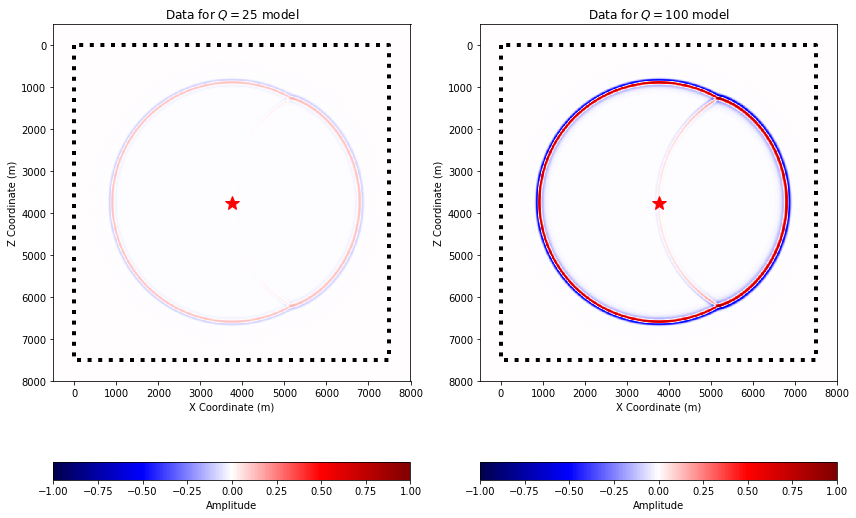

In [34]:
# NBVAL_IGNORE_OUTPUT

# Plot the two wavefields, normalized to Q=100 (the larger amplitude)
amax_Q25  = 1.0 * np.max(np.abs(uQ25.data[1,:,:]))
amax_Q100 = 1.0 * np.max(np.abs(u.data[1,:,:]))
print("amax Q= 25; %12.6f" % (amax_Q25))
print("amax Q=100; %12.6f" % (amax_Q100))

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(uQ25.data[1,:,:] / amax_Q100), cmap="seismic", 
           vmin=-1, vmax=+1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'black', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Data for $Q=25$ model")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(u.data[1,:,:] / amax_Q100), cmap="seismic",
           vmin=-1, vmax=+1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot([origin[0], origin[0], extent[0], extent[0], origin[0]],
         [origin[1], extent[1], extent[1], origin[1], origin[1]],
         'black', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Data for $Q=100$ model")

plt.tight_layout()
None
# if b_mod > 0:
#     copy_of_right = np.array(u.data[1, :, :])
# elif b_mod < 0:
# if v_mod > 0:
#     vcopy_of_right = np.array(u.data[1, :, :])
# elif v_mod < 0:
#     vcopy_of_left = np.array(u.data[1, :, :])

## Plot the computed Q=25 and Q=100 receiver gathers

amax Q= 25;     4.204877
amax Q=100;     4.215780
Vel right
1.4 1.7


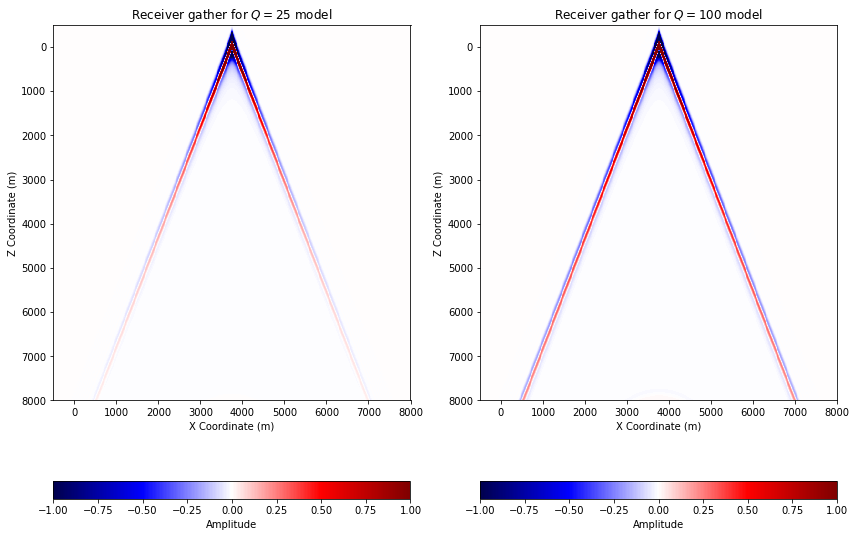

In [35]:
# NBVAL_IGNORE_OUTPUT

# Plot the two receiver gathers, normalized to Q=100 (the larger amplitude)
amax_Q25  = 0.1 * np.max(np.abs(recQ25.data[:]))
amax_Q100 = 0.1 * np.max(np.abs(rec.data[:]))
print("amax Q= 25; %12.6f" % (amax_Q25))
print("amax Q=100; %12.6f" % (amax_Q100))

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(recQ25.data[:,:] / amax_Q100, cmap="seismic", 
           vmin=-1, vmax=+1, extent=plt_extent, aspect="auto")
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Receiver gather for $Q=25$ model")

plt.subplot(1, 2, 2)
plt.imshow(rec.data[:,:] / amax_Q100, cmap="seismic",
           vmin=-1, vmax=+1, extent=plt_extent, aspect="auto")
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Receiver gather for $Q=100$ model")

plt.tight_layout()
None
if b_mod > 0:
    rec_dr = np.array(rec.data)
    print("Dense right")
if b_mod < 0:
    rec_dl = np.array(rec.data)
    print("Dense left")
if v_mod > 0:
    rec_vr = np.array(rec.data)
    print("Vel right")
if v_mod < 0:
    rec_vl = np.array(rec.data)
    print("Vel left")
print(vmin, vmax)

## Show the output from Devito solving for the stencil

Note this takes a **long time** ... about 50 seconds, but obviates the need to solve for the time update expression as we did above.

If you would like to see the time update equation as generated by Devito symbolic optimization, uncomment the lines for the solve below.

In [167]:
# NBVAL_IGNORE_OUTPUT

# Define the partial_differential equation
# Note the backward shifted time derivative is obtained via u.dt(x0=t-0.5*t.spacing) 
# pde = (b / m**2) * (wOverQ_100 * u.dt(x0=t-0.5*t.spacing) + u.dt2) -\
#         (b * u.dx(x0=x+0.5*x.spacing)).dx(x0=x-0.5*x.spacing) -\
#         (b * u.dz(x0=z+0.5*z.spacing)).dz(x0=z-0.5*z.spacing)

# Uncomment the next 5 lines to see the equation as generated by Devito
# t1 = timer()
# stencil = Eq(u.forward, solve(pde, u.forward))
# t2 = timer()
# print("solve ran in %.4f seconds." % (t2-t1)) 
# stencil

## Discussion

This concludes the implementation of the nonlinear forward operator. This series continues in the next notebook that describes the implementation of the Jacobian linearized forward and adjoint operators.

[sa_02_iso_implementation2.ipynb](sa_02_iso_implementation2.ipynb)


## References

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1


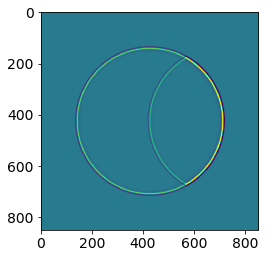

In [64]:
# copy_of_right.shape
plt.imshow(copy_of_right.T)

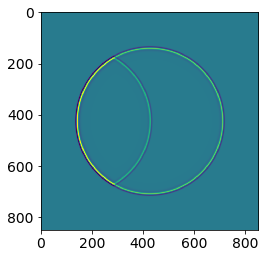

In [80]:
plt.imshow(copy_of_left.T)

In [81]:
tol = 1e-1
for i in range(copy_of_right.shape[0]):
    flag = False
    for j in range(copy_of_right.shape[1]):
        if abs(copy_of_right[i, j] - copy_of_left[-i-1, j]) > tol:
            flag = True
            break
    if flag:
        print("Not identical")
        break
else:
    print("Essentially identical")


Not identical


Text(0.5,1,'L-R Difference (Density)')

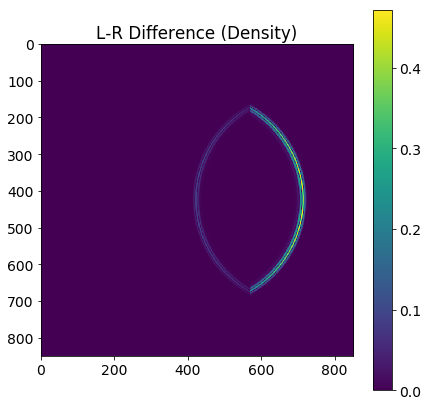

In [88]:
lr_diff = np.zeros(copy_of_right.shape)
for i in range(lr_diff.shape[0]):
    for j in range(lr_diff.shape[1]):
        lr_diff[i, j] = abs(copy_of_right[i, j] - copy_of_left[-i-1, j])

fig = plt.figure(figsize=(7, 7))
plt.imshow(lr_diff.T)
plt.colorbar()
plt.title("L-R Difference (Density)")

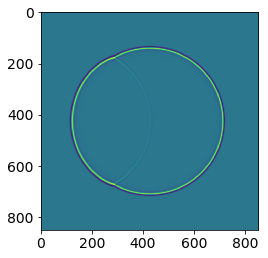

In [105]:
plt.imshow(vcopy_of_left.T)

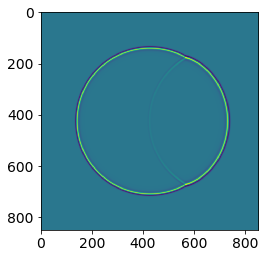

In [120]:
plt.imshow(vcopy_of_right.T)

5.995204332975845e-15


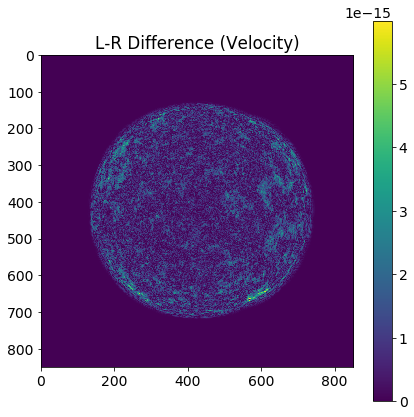

In [124]:
vlr_diff = np.zeros(copy_of_right.shape)
for i in range(vlr_diff.shape[0]):
    for j in range(vlr_diff.shape[1]):
        vlr_diff[i, j] = abs(vcopy_of_right[i, j] - vcopy_of_left[-i-1, j])

fig = plt.figure(figsize=(7, 7))
plt.imshow(vlr_diff.T)
plt.colorbar()
plt.title("L-R Difference (Velocity)")
print(np.max(vlr_diff))

Text(0.5,1,'Receiver data - RHS velocity shelf')

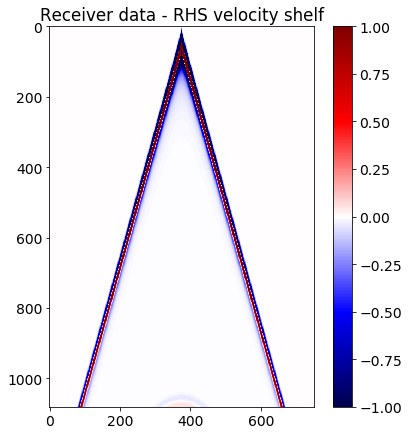

In [205]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(rec_vr, vmin=-1, vmax=1, cmap='seismic')
plt.colorbar()
plt.title("Receiver data - RHS velocity shelf")

Text(0.5,1,'Receiver data - LHS velocity shelf')

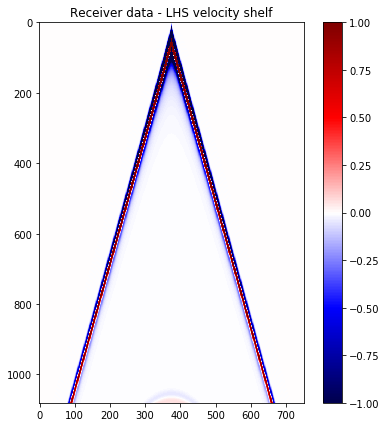

In [20]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(rec_vl, vmin=-1, vmax=1, cmap='seismic')
plt.colorbar()
plt.title("Receiver data - LHS velocity shelf")

Text(0.5,1,'Receiver data - RHS - LHS')

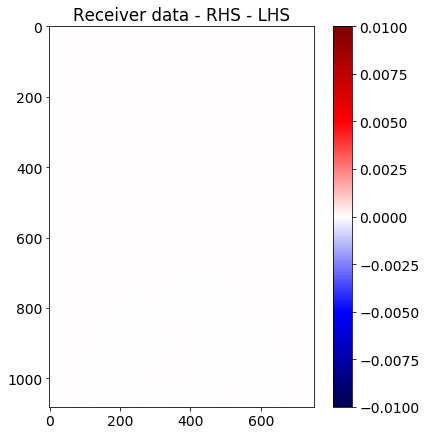

In [207]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(rec_vr - rec_vl, vmin=-0.01, vmax=0.01, cmap='seismic')
plt.colorbar()
plt.title("Receiver data - RHS - LHS")

Text(0.5,1,'Receiver data - LHS density shelf')

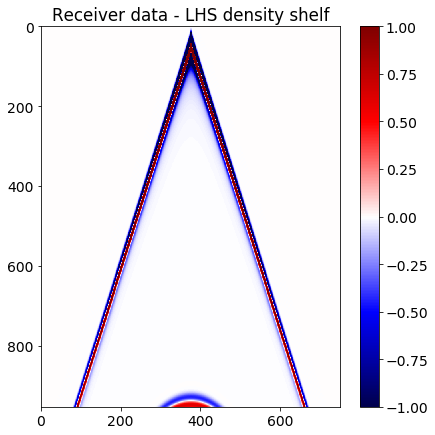

In [208]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(rec_dl, vmin=-1, vmax=1, cmap='seismic')
plt.colorbar()
plt.title("Receiver data - LHS density shelf")

Text(0.5,1,'Receiver data - RHS density shelf')

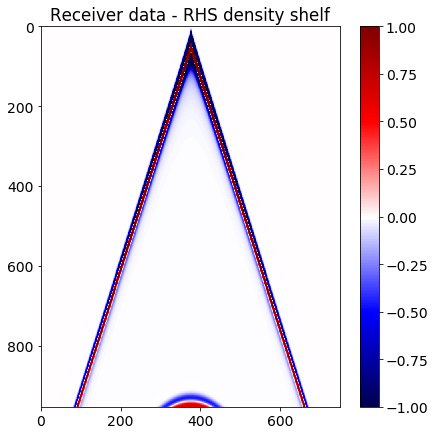

In [209]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(rec_dr, vmin=-1, vmax=1, cmap='seismic')
plt.colorbar()
plt.title("Receiver data - RHS density shelf")

Text(0.5,1,'Receiver data - RHS - LHS density shelf')

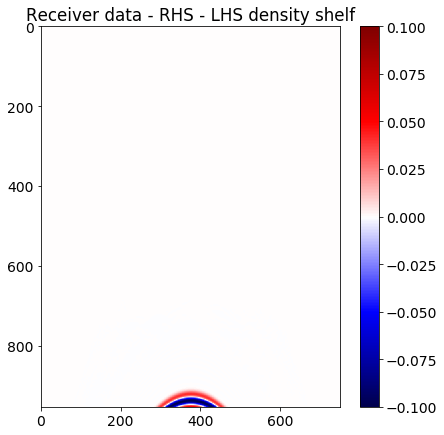

In [210]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(rec_dr - rec_dl, vmin=-0.1, vmax=0.1, cmap='seismic')
plt.colorbar()
plt.title("Receiver data - RHS - LHS density shelf")

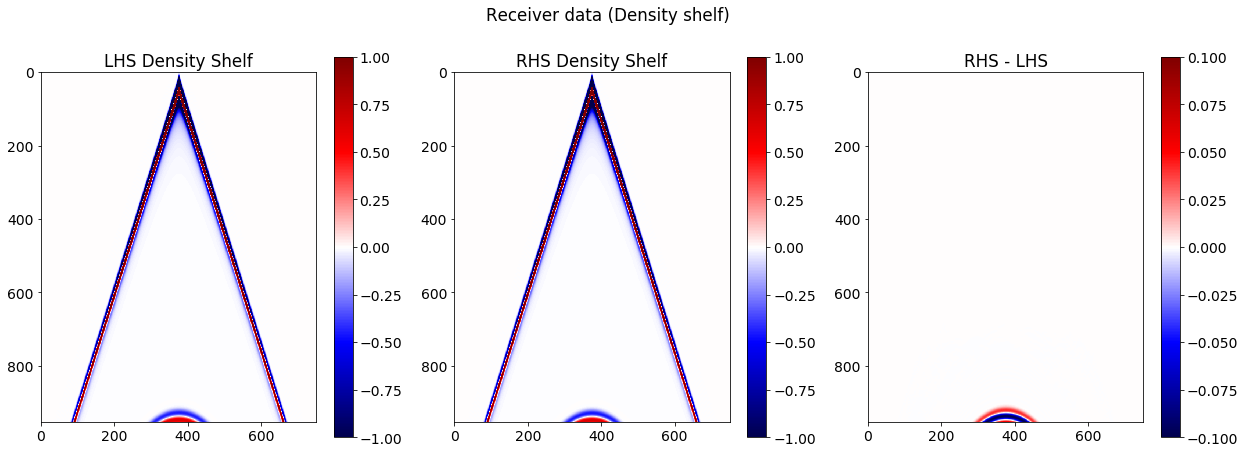

In [218]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
plt.suptitle("Receiver data (Density shelf)")
im0 = axs[0].imshow(rec_dl, vmin=-1, vmax=1, cmap='seismic')
axs[0].set_title('LHS Density Shelf')
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(rec_dr, vmin=-1, vmax=1, cmap='seismic')
axs[1].set_title('RHS Density Shelf')
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(rec_dr - rec_dl, vmin=-0.1, vmax=0.1, cmap='seismic')
axs[2].set_title('RHS - LHS')
fig.colorbar(im2, ax=axs[2])

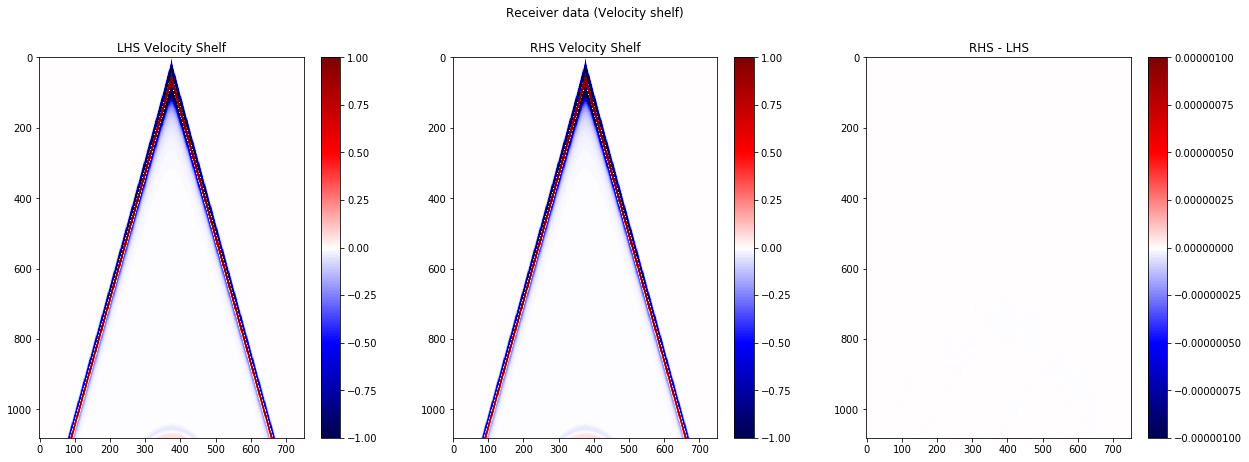

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
plt.suptitle("Receiver data (Velocity shelf)")
im0 = axs[0].imshow(rec_vl, vmin=-1, vmax=1, cmap='seismic')
axs[0].set_title('LHS Velocity Shelf')
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(rec_vr, vmin=-1, vmax=1, cmap='seismic')
axs[1].set_title('RHS Velocity Shelf')
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(rec_vr - rec_vl, vmin=-1e-6, vmax=1e-6, cmap='seismic')
axs[2].set_title('RHS - LHS')
fig.colorbar(im2, ax=axs[2])

Text(0.5,1,'RHS Density Shelf')

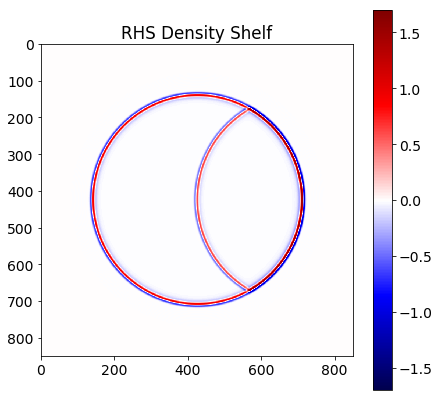

In [225]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(copy_of_right.T, cmap='seismic', vmin=-1.7, vmax=1.7)
plt.colorbar()
plt.title("RHS Density Shelf")

Text(0.5,1,'LHS Density Shelf')

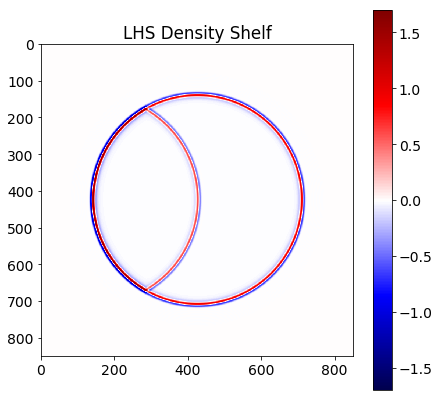

In [226]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(copy_of_left.T, cmap='seismic', vmin=-1.7, vmax=1.7)
plt.colorbar()
plt.title("LHS Density Shelf")

Text(0.5,1,'LHS Velocity Shelf')

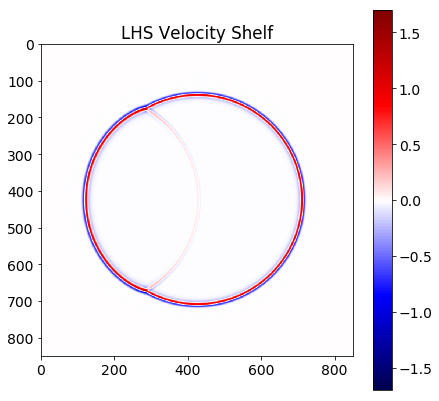

In [227]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(vcopy_of_left.T, cmap='seismic', vmin=-1.7, vmax=1.7)
plt.colorbar()
plt.title("LHS Velocity Shelf")

Text(0.5,1,'RHS Velocity Shelf')

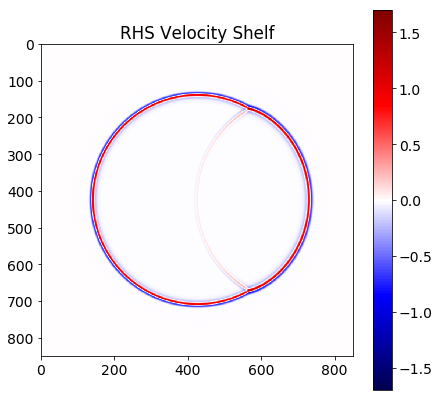

In [228]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(vcopy_of_right.T, cmap='seismic', vmin=-1.7, vmax=1.7)
plt.colorbar()
plt.title("RHS Velocity Shelf")